### In this notebook, Upsampling with logistic regression is used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

In [2]:
df_train = pd.read_csv("2020_Competition_Training (1).csv")
df_train["train"] = 1
df_test = pd.read_csv("2020_Competition_Holdout .csv")
df_test["train"] = 0
df_test["transportation_issues"] = "NA"
df = pd.concat([df_train, df_test])
df.reset_index(inplace=True)

df.shape #87253 rows with 828 features
#df.drop("person_id_syn", axis=1, inplace=True)
#df= pd.get_dummies(df)
#df.fillna(0,inplace=True)

/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (80,193) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (79) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(87253, 828)

In [3]:
#df.to_csv("merge_data.csv")

In [4]:
df_columns = df.columns.tolist()
df_columns.remove("transportation_issues")
#Columns with missing value
columns_with_missing = []
for column in df_columns:
    if df[column].isnull().sum()>0:
        columns_with_missing.append({"column":column, "missing":df[column].isnull().sum()})
df_missing_distribution = pd.DataFrame.from_dict(columns_with_missing)
df_missing_distribution.sort_values("missing",ascending=False).reset_index(inplace=True)
df_missing_distribution.to_csv("missing_value.csv")
from sklearn.impute import SimpleImputer
# rank 1 blood fat screen or control
# rank 2 data from cons about demos
# rank 3 cms data insurance factor data.
imputer_frequent = SimpleImputer(strategy="most_frequent")
for column in df_missing_distribution["column"]:
    try:
        if df[column].nunique()>=30:
            df[column].fillna(df[column].mean(),inplace=True)
        else:
            df[column].fillna(df[column].value_counts().index[0],inplace=True)
    except:
        print(column)

In [5]:
df_train = df[df["train"]==1]
df_train.dropna(axis=1,inplace=True)
df_hold = df[df["train"]==0]

y = df_train["transportation_issues"]
y = y.astype("int")
x = df_train.drop(["index","person_id_syn"], axis=1)

/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [7]:
from sklearn.utils import resample
X = x_train.copy()
X["transportation_issues"] = y_train
# separate minority and majority classes
wo_tran = X[X["transportation_issues"]==0]
tran = X[X["transportation_issues"]==1]

# upsample minority
tran_upsampled = resample(tran,
                          replace=True, # sample with replacement
                          n_samples=len(wo_tran), # match number in majority class
                          random_state=42) # reproducible results

upsampled = pd.concat([wo_tran,tran_upsampled])

# check new class counts
upsampled["transportation_issues"].value_counts()

1    41536
0    41536
Name: transportation_issues, dtype: int64

In [8]:
y_train = upsampled["transportation_issues"]
x_train = upsampled.drop("transportation_issues",axis=1)
x_train = pd.get_dummies(x_train)

x_test.drop("transportation_issues",axis=1, inplace=True)
x_test = pd.get_dummies(x_test)
x_train,x_test = x_train.align(x_test, join="left", axis=1)

/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
# evaluate pca with logistic regression algorithm for classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# define transform
scaler = MinMaxScaler()
pca = PCA(n_components=6)
# prepare transform on dataset
x_train = scaler.fit_transform(x_train)
x_train = pca.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_test[np.isnan(x_test)] = 0
x_test = pca.fit_transform(x_test)

/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver = "lbfgs", penalty="l2", random_state=42).fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [11]:
y_prob = clf.predict_proba(x_test)

In [12]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))
(y_test==y_pred).mean() #accuracy 86.87%

#False negative values are larger than the false positive values.

[[10520  7319]
 [  966  2067]]


0.6030567267152166

In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.635611308290014

ROC_AUC Score:
0.635611308290014


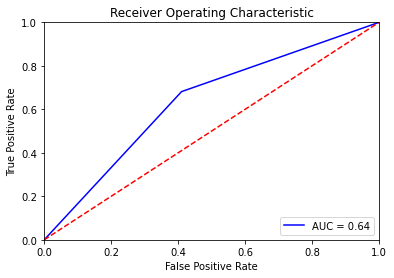

In [14]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

print("ROC_AUC Score:")
print(roc_auc_score(y_test, y_pred))

#ROC Plot
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()